<a href="https://colab.research.google.com/github/ugeshe/Reliable_Airline_to_Bay_Area/blob/main/Dallas_SanJose_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Airline Delay Analysis – San Jose (SJC)
**Background:** Flight delays can result from weather, air traffic control, airport operations, or the airline itself.


**Goal:** Identify airlines with the **fewest delays caused by the airline** for flights into **San Jose (SJC)** in the last 5 years.

**Delay Definition (BTS):** A flight is **on time** if it arrives within **15 minutes** of its scheduled gate arrival. Otherwise, it is considered delayed.

**Dataset:** [U.S. Bureau of Transportation Statistics](https://transtats.bts.gov/OT_Delay/OT_DelayCause1.asp) – June 2003 to April 2025.



.  

In [47]:
#Install requried libraies
!pip install -q pandas matplotlib seaborn plotly

#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

### Dataset




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


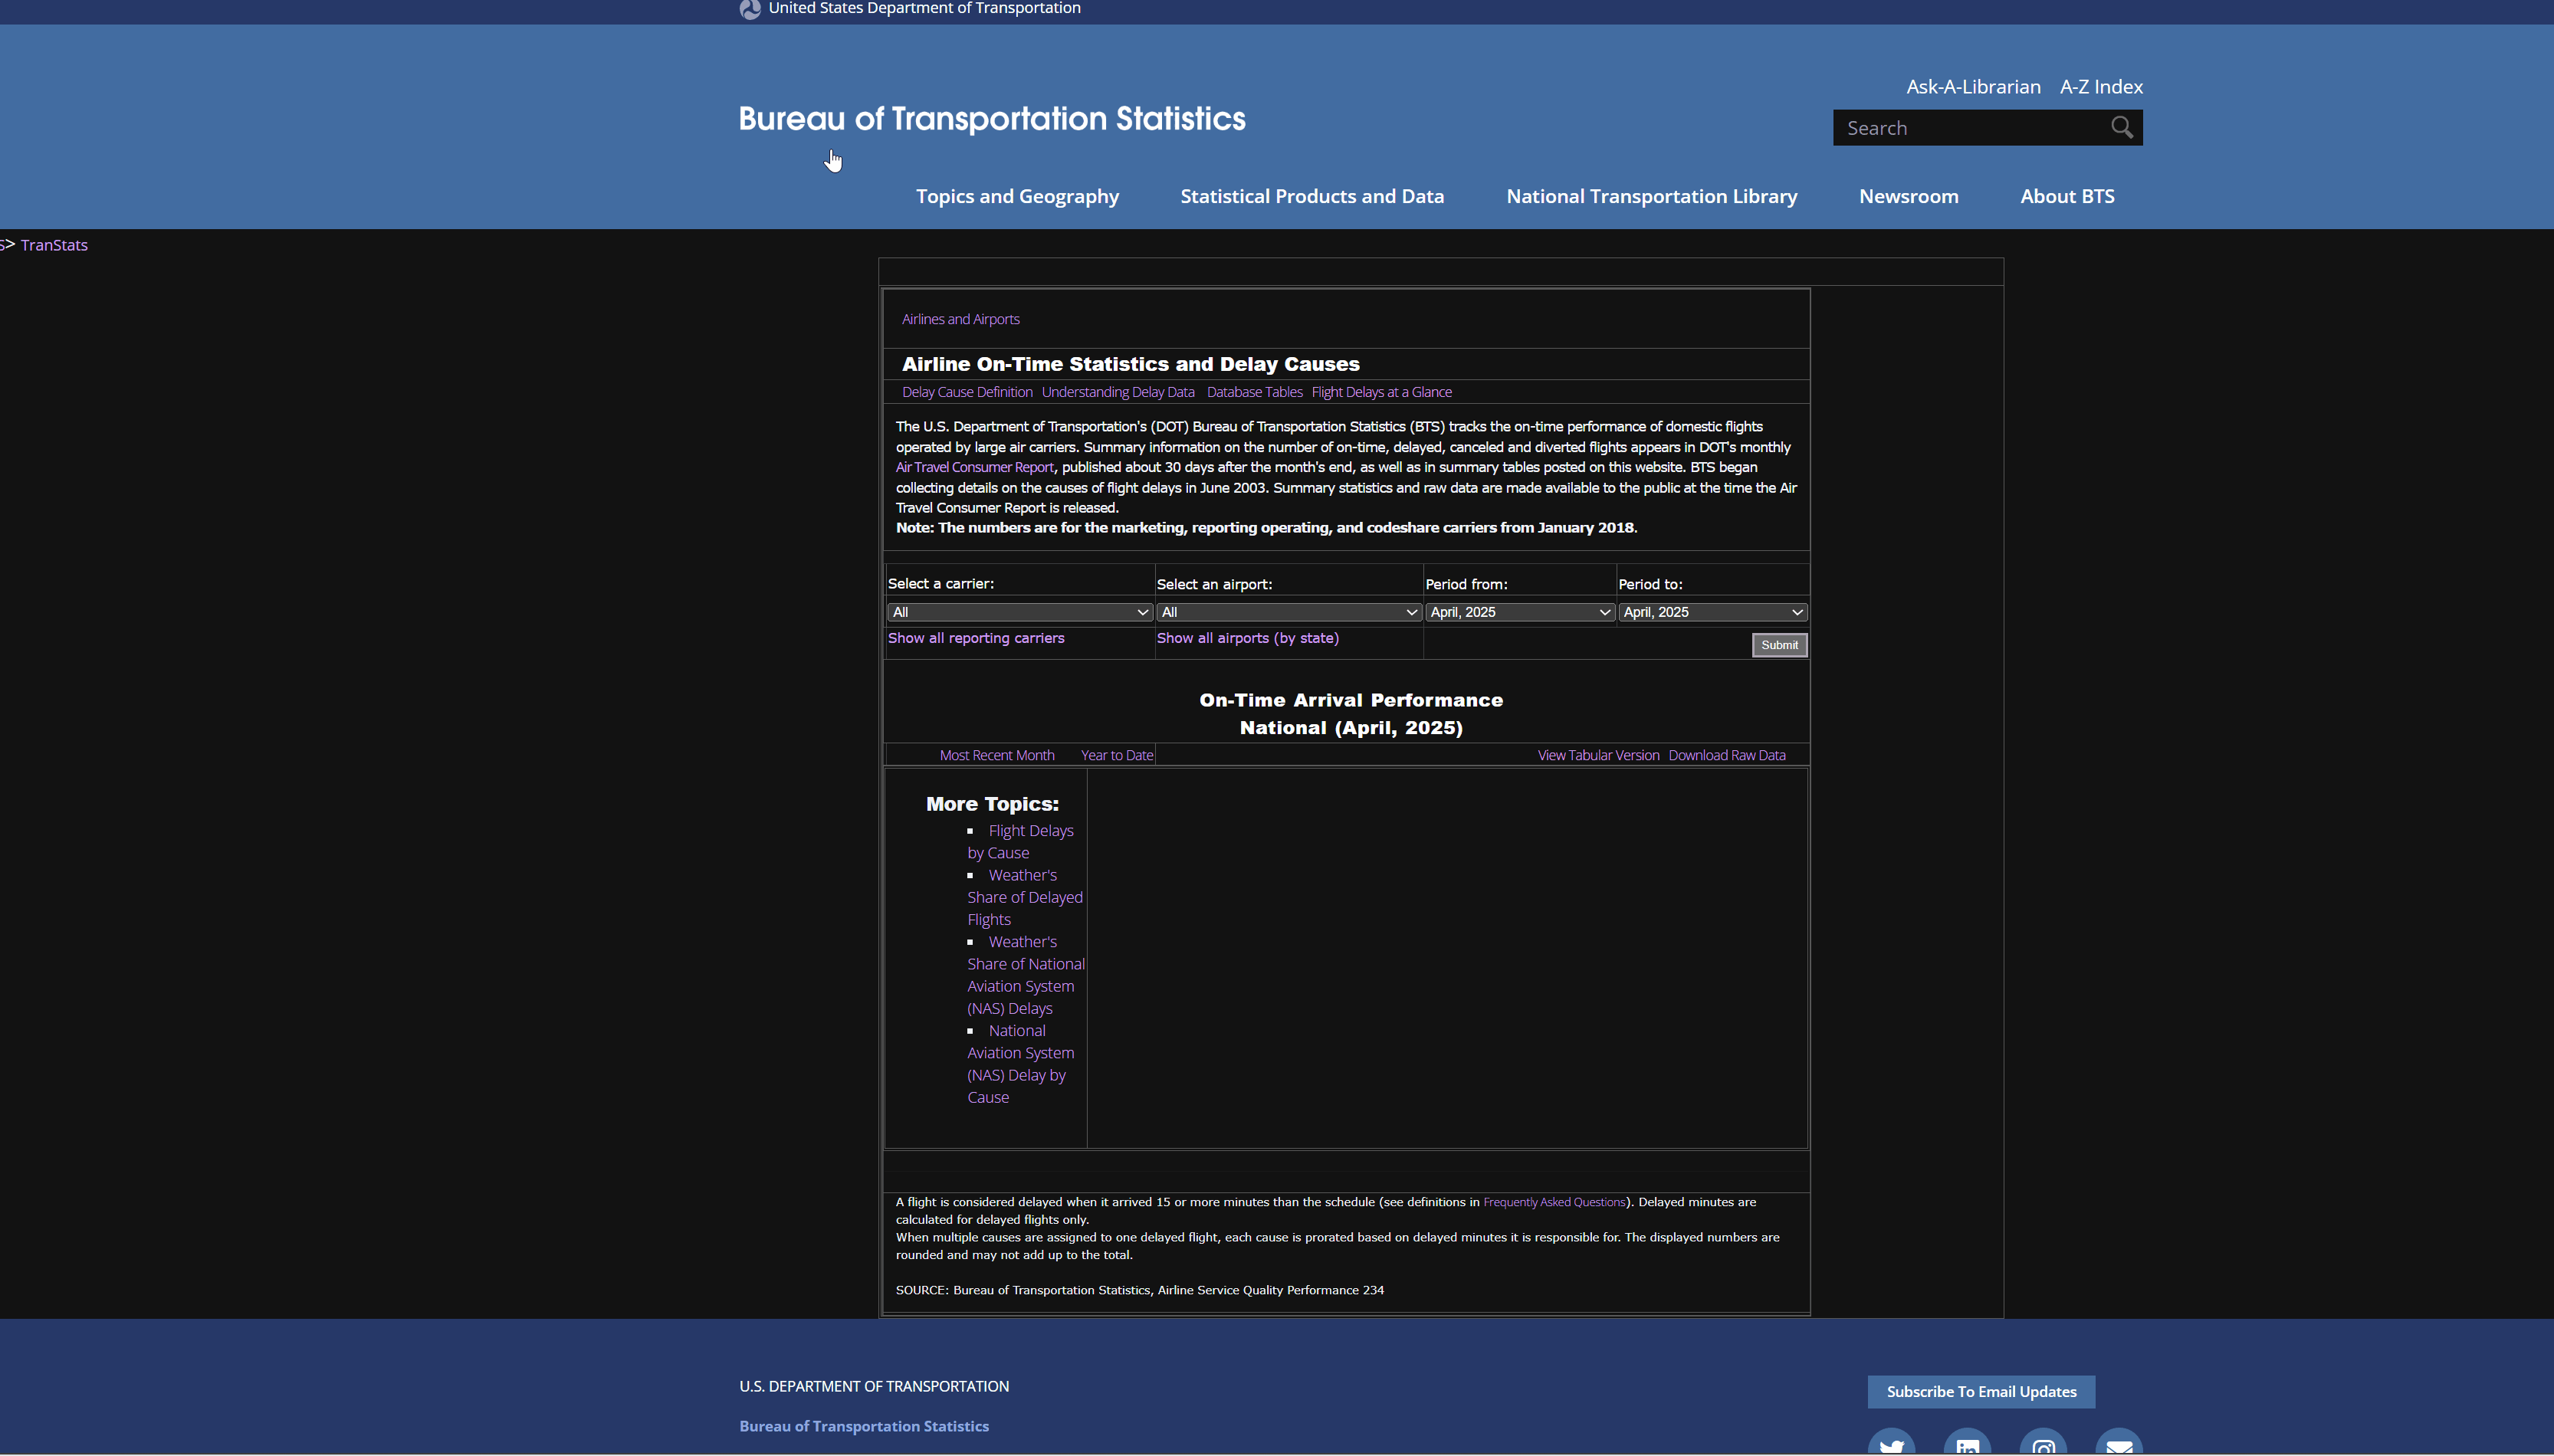

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2025,4,G4,Allegiant Air,SCK,"Stockton, CA: Stockton Metro",32.0,6.0,0.73,0.59,...,0.00,2.72,0.0,0.0,169.0,46.0,10.0,50.0,0.0,63.0
1,2025,4,G4,Allegiant Air,SDF,"Louisville, KY: Louisville Muhammad Ali Intern...",50.0,20.0,2.90,0.36,...,1.00,10.21,0.0,0.0,1382.0,93.0,8.0,454.0,193.0,634.0
2,2025,4,G4,Allegiant Air,SFB,"Sanford, FL: Orlando Sanford International",885.0,285.0,54.15,13.07,...,0.21,171.47,1.0,0.0,20506.0,5460.0,1297.0,1980.0,8.0,11761.0
3,2025,4,G4,Allegiant Air,SGF,"Springfield, MO: Springfield-Branson National",67.0,11.0,2.58,0.46,...,0.00,5.86,0.0,3.0,718.0,217.0,43.0,122.0,0.0,336.0
4,2025,4,G4,Allegiant Air,SHV,"Shreveport, LA: Shreveport Regional",8.0,0.0,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')


# Load and view Dataset

from IPython.display import Image, display
display(Image(filename='/content/drive/MyDrive/Job_Search/download_dataset.gif'))

df = pd.read_csv('/content/drive/MyDrive/Job_Search/On_Time_Airlines_Dallas_San_Jose/ot_delaycause1_DL/Airline_Delay_Cause.csv')
display(df.head())

# U.S. Bureau of Transportation Statistics records flight delay causes across U.S. airports

### Data Cleaning



Steps:
1. Keep only **SJC airport** data from **2020 onwards**
2. Remove inactive carrier **Compass Airlines**
3. Keep only relevant columns
4. Check for:
   - Missing values (NaN)
   - Infinite values
   - Negative numbers for flights/delays

In [49]:
# Filter  for SJC airport and last 5 years
sjc_df = df[(df['airport'] == 'SJC') & (df['year'] >= 2020)]

# Remove inactive airlines
sjc_df = sjc_df[sjc_df['carrier_name'] != 'Compass Airlines']

# Keep relevant columns
sjc_df = sjc_df[['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name', 'arr_flights', 'carrier_ct', 'carrier_delay']]

# Data quality checks
print("\n NaN count per column:\n", sjc_df.isna().sum())

numeric_cols = sjc_df.select_dtypes(include=[np.number])
print("\nInfinite values per column:\n", np.isinf(numeric_cols).sum())

# Check if number of flight and carrier's are negative
neg_rows  = sjc_df[ (sjc_df['arr_flights'] < 0) | (sjc_df['carrier_ct'] < 0) ]

if not neg_rows .empty:
  print(f"\n Rows with unusual negative values: {len(neg_rows )} \n")
  display(neg_rows )

print("\n Updated dataframe: \n", sjc_df.head())


 NaN count per column:
 year             0
month            0
carrier          0
carrier_name     0
airport          0
airport_name     0
arr_flights      0
carrier_ct       0
carrier_delay    0
dtype: int64

Infinite values per column:
 year             0
month            0
arr_flights      0
carrier_ct       0
carrier_delay    0
dtype: int64

 Updated dataframe: 
       year  month carrier               carrier_name airport  \
85    2025      4      HA  Hawaiian Airlines Network     SJC   
275   2025      4      NK            Spirit Airlines     SJC   
585   2025      4      OO      SkyWest Airlines Inc.     SJC   
726   2025      4      QX                Horizon Air     SJC   
1019  2025      4      AA  American Airlines Network     SJC   

                                           airport_name  arr_flights  \
85    San Jose, CA: Norman Y. Mineta San Jose Intern...         60.0   
275   San Jose, CA: Norman Y. Mineta San Jose Intern...        125.0   
585   San Jose, CA: Norman Y.

### Reliability Metrics

We calculate three metrics for each airline:

- **Average Delay**: Average delay minutes per delayed flight
- **Delay Rate**: Percentage of flights delayed
- **Delay Score**: `Average Delay × Delay Rate` → lower is better

In [50]:

# Aggregate metrics
airline_perf = sjc_df.groupby('carrier_name').agg(
    total_delays=('carrier_delay', 'sum'),
    total_flights=('arr_flights', 'sum'),
    total_delayed_flights=('carrier_ct', 'sum')
)

display(airline_perf.head())

# Calculate metrics
airline_perf['average_delay'] = airline_perf['total_delays'] / airline_perf['total_delayed_flights']
airline_perf['delay_rate'] = (airline_perf['total_delayed_flights'] / airline_perf['total_flights']) * 100
airline_perf['delay_score'] = airline_perf['average_delay'] * airline_perf['delay_rate']

display(airline_perf.head())

,total_delays,total_flights,total_delayed_flights
carrier_name,,,
Alaska Airlines Network,50493.0,16351.0,870.19
American Airlines Network,41855.0,9533.0,710.23
Delta Air Lines Network,61617.0,11219.0,786.64
Envoy Air,1332.0,507.0,28.32
Frontier Airlines,4024.0,1253.0,56.07


,total_delays,total_flights,total_delayed_flights,average_delay,delay_rate,delay_score
carrier_name,,,,,,
Alaska Airlines Network,50493.0,16351.0,870.19,58.025259,5.321937,308.806801
American Airlines Network,41855.0,9533.0,710.23,58.931614,7.450226,439.053813
Delta Air Lines Network,61617.0,11219.0,786.64,78.329350,7.011677,549.220073
Envoy Air,1332.0,507.0,28.32,47.033898,5.585799,262.721893
Frontier Airlines,4024.0,1253.0,56.07,71.767434,4.474860,321.149242


In [51]:

# Average delay (descending)
fig1 = px.bar(
    airline_perf.sort_values(by='average_delay', ascending=False),
    x=airline_perf.sort_values(by='average_delay', ascending=False).index,
    y='average_delay',
    title='Average Delay Time per Airline at SJC',
    labels={'x': 'Airline', 'average_delay': 'Average Delay (minutes)'},
    color='average_delay'
)
fig1.show()

In [52]:
# Delay rate (descending)
fig2 = px.bar(
    airline_perf.sort_values(by='delay_rate', ascending=False),
    x=airline_perf.sort_values(by='delay_rate', ascending=False).index,
    y='delay_rate',
    title='Delay Rate per Airline at SJC',
    labels={'x': 'Airline', 'delay_rate': 'Delay Rate (%)'},
    color='delay_rate'
)
fig2.show()

**Reasoning**:
Finally, I will add a markdown cell to explain the concept of the 'delay score' and the third plot. Then I will modify the third plot to have a more descriptive title. This completes the final two steps of the subtask.



In [53]:
# Delay score (ascending, because lower is better)
fig3 = px.bar(
    airline_perf.sort_values(by='delay_score', ascending=True),
    x=airline_perf.sort_values(by='delay_score', ascending=True).index,
    y='delay_score',
    title='Overall Delay Score per Airline at SJC (Lower is Better)',
    labels={'x': 'Airline', 'delay_score': 'Delay Score'},
    color='delay_score'
)
fig3.show()

## 6. Conclusion

**Top 3 most reliable airlines into SJC (2020–2025)**  
*(Airline-caused delays only)*  
1. **Horizon Air** *(Alaska Airlines group)*  
2. **Southwest Airlines**  
3. **Envoy Air** *(American Airlines group)*  

**Key takeaways:**
- Rankings are based on **Delay Score** = *Average Delay × Delay Rate*, balancing both frequency and severity of delays.
- These airlines consistently have **fewer and shorter delays** caused by the airline itself, excluding weather, air traffic control, and other external factors.
